Currently the dask version, is slowwer espeically for full data, 
NEED to check hwo dask will run over ssh like this..

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
np=n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari
from datetime import datetime

from dask.distributed import Client
import dask_image.ndfilters
from dask import array as darr

In [2]:
import detection3d_bench as det3d
import utils_bench as utils

In [3]:
def calculate_corrmap_for_batch_par(mov, npil_filt_size, unif_filt_size, intensity_thresh, do_sdnorm=True, np_filt_type='unif', conv_filt_type = 'unif' , sdnorm_exp = 1.0, dtype=None):
    """ This version, is more like the original, version, where I created dask version of each of the functions, trying to do minimal
    changes.

    """
    if dtype is None: dtype = n.float32
    nt, nz, ny, nx = mov.shape
    # log_cb("Rolling mean filter", 3)
    # mean_img[:] = mean_img * (n_frames_proc - nt) / n_frames_proc + mov.mean(axis=0) * nt / n_frames_proc
    # max_img[:] = n.maximum(max_img, mov.max(axis=0))

    #change input mov to dask array, via changing calculate_corr_mapp, when this function is working
    temporal_hpf = nt
    spatial_chunks = (-1,nz,int(ny//20),int(nx//20))
    time_chunks = (int(nt//30),nz,ny,nx)

    mov = darr.asarray(mov)
    mov.rechunk(spatial_chunks)


    mov = det3d.hp_rolling_mean_filter_p(mov, int(temporal_hpf))
    # for i in range(0, mov.shape[0], int(temporal_hpf)):
    #     mov[i:i + int(temporal_hpf),] -= mov[i:i + int(temporal_hpf)].mean(axis=0)    

    # log_cb("Stdev over time",3)


    sdmov = darr.zeros_like(mov)
    if do_sdnorm:
        sdmov += det3d.standard_deviation_over_time_p(mov, batch_size=nt, sqrt=False)
        sdmov = darr.sqrt(darr.maximum(1e-10, sdmov / nt))
    
    else:
        # log_cb("Skipping sdnorm", 3)
        sdmov = 1
    if sdnorm_exp != 1.0:
        sdmov = sdmov ** sdnorm_exp

    mov[:] = mov[:] / sdmov

    #optimsie by deleting unneeded functions
    del sdmov
    mov.rechunk(time_chunks)

    # log_cb("Sub and conv", 3)

    # Runs to here quikcly, but is slow here on
    mov = det3d.np_sub_and_conv3d_p(
        mov, npil_filt_size, unif_filt_size,
        np_filt_type=np_filt_type, conv_filt_type = conv_filt_type)



    # log_cb("Vmap", 3)
    mov.rechunk(spatial_chunks)

    vmap = darr.zeros((nz,ny,nx))
    vmap += det3d.get_vmap3d_p2(mov, intensity_thresh,
                              sqrt=True, mean_subtract=False)

    vmap = vmap.compute()
    return vmap

In [3]:
def calculate_corrmap_for_batch_par_inline(mov, npil_filt_size, unif_filt_size, intensity_thresh, do_sdnorm=True, np_filt_type='unif', conv_filt_type = 'unif' , sdnorm_exp = 1.0, dtype=None):
    """Parallel/dask implementation, ran for cropped movies, but for the larger crop it runs slower.. function made to run without
     calling other modules """
    if dtype is None: dtype = n.float32

    nt, nz, ny, nx = mov.shape
    temporal_hpf = nt
    #log_cb("Rolling mean filter", 3)
    # mean_img[:] = mean_img * (n_frames_proc - nt) / n_frames_proc + mov.mean(axis=0) * nt / n_frames_proc
    # max_img[:] = n.maximum(max_img, mov.max(axis=0))



    spatial_chunks = (-1,nz,int(ny//20),int(nx//20))
    time_chunks = (int(nt//30),nz,ny,nx)

    #basic highpass filter
    mov = darr.asarray(mov)
    mov.rechunk(spatial_chunks)

    for i in range(0, nt, temporal_hpf):
        mov[i:i+temporal_hpf] = mov[i:i+temporal_hpf] - mov[i:i+temporal_hpf].mean(axis=0) # subtracts mean of a width


    #log_cb("Stdev over time",3)

    sdmov2 = darr.zeros_like(mov)
    sdmov2.rechunk(spatial_chunks)
    if do_sdnorm:
        sdmov2 += (((darr.diff(mov, axis=0) ** 2).sum(axis=0)) / nt)  #standard deviation of each array point through time
        sdmov = darr.sqrt(darr.maximum(10 ** -9,sdmov2))

    if sdnorm_exp != 1.0:
        sdmov = sdmov ** sdnorm_exp


    mov[:] = mov[:] / sdmov

 
    del sdmov
    del sdmov2

    mov.rechunk(time_chunks)


    c1 = dask_image.ndfilters.uniform_filter(darr.ones((nz,ny,nx)), np.asarray(npil_filt_size).astype(int), mode='constant')
    #c2 = dask_image.ndfilters.gaussian_filter(darr.ones((nz,ny,nx)), unif_filt_size, mode='constant')

    #each time step apply the neuropil filter
    np_mov = darr.zeros_like(mov)
    for i in range(len(mov[0])):
        np_mov[i] = dask_image.ndfilters.uniform_filter(mov[i], np.asarray(npil_filt_size).astype(int), mode='constant') / c1


    np_sub_mov = mov - np_mov # removes the neuropil from the normalised image

    del np_mov


    #applies a cell detection filter
    cv_mov = darr.zeros_like(mov)
    for i in range(len(mov[0])):
        cv_mov[i] = dask_image.ndfilters.gaussian_filter(np_sub_mov[i], unif_filt_size, mode='constant') * unif_filt_size[-1]

    del np_sub_mov

    # #removes values below a threshold, and sum over time
    # cv_mov.rechunk(spatial_chunks)
    # vmap = (((cv_mov ** 2) * (cv_mov > intensity_thresh).astype(int)).sum(axis=0) ** 0.5)
    # vmap = vmap.compute()
    cv_mov = cv_mov.compute()
    return cv_mov #vmap 

In [12]:
def calculate_corrmap_for_batch(mov, sdmov2, vmap2, mean_img, max_img, temporal_hpf, npil_filt_size, unif_filt_size, intensity_thresh, n_frames_proc=0,n_proc=12, mproc_batchsize = 50, mov_sub_save_path=None, return_mov_filt=False, do_sdnorm=True, np_filt_type='unif', conv_filt_type = 'unif' , sdnorm_exp = 1.0, fix_vmap_edges=True, dtype=None):
    if dtype is None: dtype = n.float32
    nt, nz, ny, nx = mov.shape
    # log_cb("Rolling mean filter", 3)
    # mean_img[:] = mean_img * (n_frames_proc - nt) / n_frames_proc + mov.mean(axis=0) * nt / n_frames_proc
    # max_img[:] = n.maximum(max_img, mov.max(axis=0))

    # shmem_mov_sub, shmem_par_mov_sub, mov_sub = utils.create_shmem_from_arr(mov, copy=True)
    # del mov
    mov = det3d.hp_rolling_mean_filter(mov, int(temporal_hpf), copy=False)
    # det3d.hp_rolling_mean_filter_mp(
        # shmem_par_mov_sub, temporal_hpf, nz=nz, n_proc=n_proc)
    # print(mov_sub.std())
    # return
    # log_cb("Stdev over time",3)
    if do_sdnorm:
        sdmov2 += det3d.standard_deviation_over_time(mov, batch_size=nt, sqrt=False)
        sdmov = n.sqrt(n.maximum(1e-10, sdmov2 / nt))
    else:
        # log_cb("Skipping sdnorm", 3)
        sdmov = 1
    if sdnorm_exp != 1.0:
        sdmov = sdmov ** sdnorm_exp

    mov[:] = mov[:] / sdmov
    if return_mov_filt:
        sdnorm_mov = mov.copy()
    # log_cb("Sharr creation",3)
    shmem_mov_sub, shmem_par_mov_sub, mov_sub = utils.create_shmem_from_arr(mov, copy=True)
    del mov
    shmem_mov_filt, shmem_par_mov_filt, mov_filt = utils.create_shmem_from_arr(
        mov_sub, copy=False)
    # log_cb("Sub and conv", 3)
    # print(shmem_par_mov_filt)
    # print(shmem_par_mov_sub)
    det3d.np_sub_and_conv3d_split_shmem(
        shmem_par_mov_sub, shmem_par_mov_filt, npil_filt_size, unif_filt_size, n_proc=n_proc, batch_size=mproc_batchsize,
        np_filt_type=np_filt_type, conv_filt_type = conv_filt_type)
    if mov_sub_save_path is not None:
        n.save(mov_sub_save_path, mov_sub.astype(dtype))
    # log_cb("Vmap", 3)
    # vmap2 += det3d.get_vmap3d(mov_filt, intensity_thresh,
    #                           sqrt=False, mean_subtract=False, fix_edges=fix_vmap_edges)
    # if return_mov_filt:
    #     retfilt = mov_filt.copy()
    #     retsub = mov_sub.copy()
    # shmem_mov_sub.close(); shmem_mov_sub.unlink()
    # shmem_mov_filt.close(); shmem_mov_filt.unlink()
    # vmap = np.sqrt(vmap2)
    return mov_filt #vmap

In [6]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 9
Total threads: 72,Total memory: 503.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43525,Workers: 9
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: Just now,Total memory: 503.20 GiB
Comm: tcp://127.0.0.1:39203,Total threads: 8
Dashboard: http://127.0.0.1:40369/status,Memory: 55.91 GiB
Nanny: tcp://127.0.0.1:43077,


In [4]:
# path to wherever the s2p-lbm repository is cloned on your computer
repo_path = os.path.dirname(os.path.abspath("/home/sam/Documents/LBM/s2p-lbm/suite3d"))
os.chdir(repo_path)

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu

In [5]:
results_dir = '/home/sam/Documents/Data/s3d-benchmarking/results/corr_map'
#results_dir = '/mnt/md0/s3d-benchmarking/results/corr_map'

In [6]:
job = Job('/home/sam/Documents/Data/s3d-benchmarking','benchmark-corr_map',create=False, verbosity = 3)
#job = Job('/mnt/md0/s3d-benchmarking','benchmark-corr_map',create=False, verbosity = 3)

   Found and loaded params from /home/sam/Documents/Data/s3d-benchmarking/s3d-benchmark-corr_map/params.npy


In [5]:
# %%time
# job.register_gpu()

In [7]:
mov = job.get_registered_movie('registered_fused_data', 'fused')

In [8]:
job.params['conv_filt_type'] = 'gaussian'
job.params['conv_filt_xy'] = 1.0
job.params['conv_filt_z'] = 1.0
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy'] = 5.0
job.params['npil_filt_z']=  1.5

job.params['sdnorm_exp']= 0.8
job.params['intensity_thresh'] = 0.2

job.params['t_batch_size'] = 300
job.params['n_proc_corr'] = 70
job.params['mproc_batchsize'] = 5


# crop = ((0,18), (100,1100), (100, 950))
# mov_crop = mov[crop[0][0]:crop[0][1], :,crop[1][0]:crop[1][1], 
#                crop[2][0]:crop[2][1]]

##bigger crop
crop = ((0,15), (0,300), (200,900), (200,800))
mov_crop = mov[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1], crop[2][0]:crop[2][1], crop[3][0]:crop[3][1]]

In [9]:


conv_filt_type = 'gaussian'
conv_filt_xy = 1.0
conv_filt_z = 1.0
npil_filt_type = 'unif'
npil_filt_xy = 5.0
npil_filt_z =  1.5


sdnorm_exp = 0.8
intensity_thresh = 0.2

t_batch_size = 300
n_proc_corr = 70
mproc_batchsize = 5

npil_filt_size = (npil_filt_z,npil_filt_xy,npil_filt_xy)
unif_filt_size = (conv_filt_z,conv_filt_xy,conv_filt_xy)


In [13]:
mov_crop_tz = darr.swapaxes(mov_crop, 0, 1)

In [10]:
nz,nt,ny,nx = mov_crop.shape

vmap2 = n.zeros((nz,ny,nx))
mean_img = n.zeros((nz,ny,nx))
max_img = n.zeros((nz,ny,nx))
sdmov2 = n.zeros((nz,ny,nx))

temporal_hpf = nt

mov_crop_tz = darr.swapaxes(mov_crop, 0, 1)
mov_crop_np = mov_crop_tz.compute()

calling the orginal and the parallel fun are giving different results, the high intesnity points are the same however the original image, has a higher background intensity.

tried altering function to return the filtered 4-D movie to spot where the code diverges, but juptyer notebook is crashing uppon calling the results.. e.g plt.imshow(cv_mov)

In [13]:
%%time
tic = time.time()
#(vmap, mean_img, max_img), __, __ = job.calculate_corr_map(mov = mov_crop)
#cv_mov_par = calculate_corrmap_for_batch_par_inline(mov_crop_tz, npil_filt_size, unif_filt_size, intensity_thresh, do_sdnorm=True, np_filt_type= npil_filt_type, conv_filt_type = conv_filt_type  , sdnorm_exp = sdnorm_exp , dtype=None)
cv_mov = calculate_corrmap_for_batch(mov_crop_np, sdmov2, vmap2, mean_img, max_img, temporal_hpf, npil_filt_size, unif_filt_size, intensity_thresh, n_frames_proc=nt,n_proc=12, mproc_batchsize = 50, mov_sub_save_path=None, return_mov_filt=False, do_sdnorm=True, np_filt_type=npil_filt_type, conv_filt_type = conv_filt_type , sdnorm_exp = sdnorm_exp , fix_vmap_edges=False, dtype=None)

toc = time.time()

CPU times: user 8.87 s, sys: 9.44 s, total: 18.3 s
Wall time: 27.4 s


In [16]:
print(np.std(cv_mov_par[1]))

: 

In [14]:
plt.imshow(cv_mov[1,1])

: 

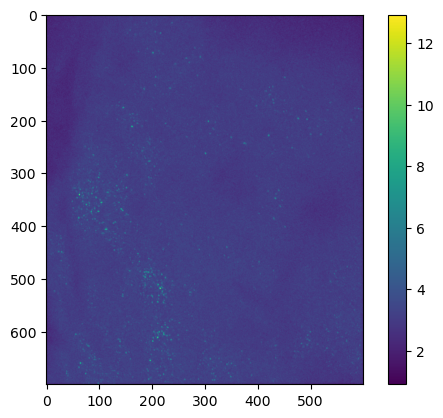

In [21]:
# base int_threshold = 


plt.imshow(vmap[2])
plt.colorbar()

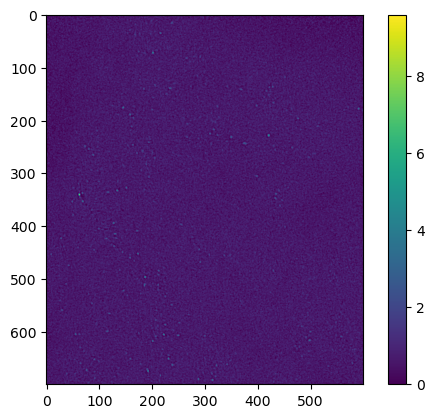

In [25]:
#par fun

plt.imshow(vmap[2])
plt.colorbar()

In [11]:
timings = {'corr_map'    : toc - tic}
outputs = {'vmap'        : vmap,
           'mean_img'    : mean_img}
repo_status = utils.get_repo_status(repo_path)

In [25]:
# this updates the baseline
# utils.save_benchmark_results(results_dir, outputs, timings, repo_status, is_baseline=True)

In [12]:
utils.benchmark(results_dir, outputs, timings, repo_status)

                                         Baseline        |      Current         | 
Branch:                             dev                  | Parallel_test        | 
Last commit hash:                   4f756530fe7b1a8b8a8b | bd539b0f194037e0e40b | 
Last commit summ:                   benchmarks for init, | Add files via upload | 
Dirty :                             True                 | True                 | 
    
Timings (s) 
corr_map                                         395.132 |              384.955 | 

Outputs: 
vmap                                                     |                      |  mismatch: 34456423 / 36835470 (6.45858 % match) 
           shape:                   (30, 1239, 991)      | (30, 1239, 991)      | 
           mean:                                   2.053 |                2.167 |
           std:                                    0.842 |                0.860 | 
mean_img                                                 |                      |  mismatch: 